# ------------------------------------------------------------------------
# Mini Project 01
## Sarah Lina HAMMOUTENE
## MSc DSBA - ESSEC & CentraleSupélec
# ------------------------------------------------------------------------

In [136]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.patches as patches
import random as rd

In [2]:
from keras.utils import to_categorical
from keras.layers import Dense
from keras.layers import Reshape
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten
from keras.layers import UpSampling2D
from keras.models import Model
from keras.layers import Dropout
from keras.layers import Dropout, Activation, Flatten

Using TensorFlow backend.


In [3]:
early_stopping_monitor = EarlyStopping(patience=3)

# ------------------------------------------------------------------------
# 1. Getting Started
# ------------------------------------------------------------------------

In [4]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

In [5]:
def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

In [6]:
def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

In [7]:
def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

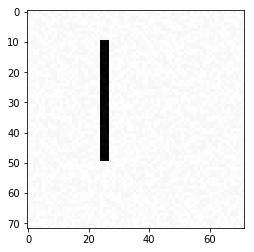

In [8]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(72,72), cmap='gray')

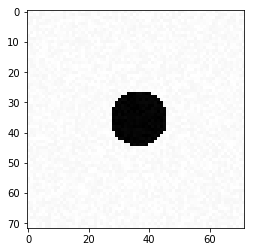

In [9]:
im = generate_a_disk(10)
plt.imshow(im.reshape(72,72), cmap='gray')

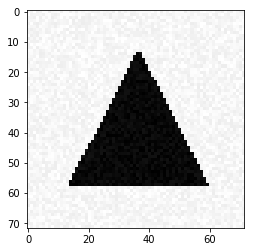

In [10]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(72,72), cmap='gray')

In [11]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data-----')
    for i in range(nb_samples):
      #  if i % 10 == 0:
       #     print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    print('Data Created')
    return [X, Y]

In [12]:
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [13]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data-----')
    for i in range(nb_samples):
       # if i % 10 == 0:
         #   print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    print('Data Created')
    return [X, Y]

In [149]:
def visualize_prediction(x, y):
    fig2, ax2 = plt.subplots(figsize=(5, 5))
    I = x.reshape((72,72))
    ax2.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax2.set_xlim([0,1])
    ax2.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax2.add_patch(tri)

    plt.show()


In [15]:
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
   # Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

# ------------------------------------------------------------------------
# 2. Simple Classification
# ------------------------------------------------------------------------

In [16]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data-----
Data Created


In [176]:
#Convert the output to categorical
target = to_categorical(Y_train)

#Get the input shape
n_cols = X_train.shape[1]

#Set the batch size
batch_size = 32

### 1.Stochastic Gradient Descent

In [18]:
model_sgd = Sequential()
model_sgd.add(Dense(3, activation='softmax', input_shape = (n_cols,)))
model_sgd.compile(optimizer='SGD' ,loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
model_sgd.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________


In [27]:
model_sgd.fit(X_train, target, batch_size= batch_size ,validation_split=0.3, epochs=100, callbacks = [early_stopping_monitor])

Train on 210 samples, validate on 90 samples
Epoch 1/100
210/210 [==============================] - 0s 100us/step - loss: 6.0933 - acc: 0.4905 - val_loss: 5.7632 - val_acc: 0.5444
Epoch 2/100
210/210 [==============================] - 0s 96us/step - loss: 5.9329 - acc: 0.4905 - val_loss: 6.4348 - val_acc: 0.5111
Epoch 3/100
210/210 [==============================] - 0s 97us/step - loss: 5.5296 - acc: 0.6143 - val_loss: 6.1941 - val_acc: 0.5222


In [28]:
X_test_disk = generate_a_disk()
X_test_disk = X_test_disk.reshape(1, X_test_disk.shape[0])
pred_disk_sgd = model_sgd.predict(X_test_disk)

In [29]:
pred_disk_sgd

array([[ 1.,  0.,  0.]], dtype=float32)

### --------It doesn't work 

- As we can see the Stochastic Gradient Descent gives us an accuracy of around 60 %
- In particular for our test, we can clearly see that the predicted class is wrong, here the network's output is a rectangle and we are dealing with a circle 

# ----------------------------------
### 2. Adam Optimizer

In [23]:
model_adam = Sequential()
model_adam.add(Dense(3, activation='softmax', input_shape = (n_cols,)))
model_adam.compile(optimizer='adam' ,loss='categorical_crossentropy',metrics=['accuracy'])

In [24]:
early_stopping_monitor = EarlyStopping(patience=2)
model_adam.fit(X_train, target, batch_size= 32 ,validation_split=0.3, epochs=100, callbacks = [early_stopping_monitor])

Train on 210 samples, validate on 90 samples
Epoch 1/100
210/210 [==============================] - 0s 2ms/step - loss: 2.3901 - acc: 0.3810 - val_loss: 2.1657 - val_acc: 0.3889
Epoch 2/100
210/210 [==============================] - 0s 99us/step - loss: 1.5483 - acc: 0.4286 - val_loss: 1.4065 - val_acc: 0.3889
Epoch 3/100
210/210 [==============================] - 0s 99us/step - loss: 0.9043 - acc: 0.4952 - val_loss: 0.7782 - val_acc: 0.7111
Epoch 4/100
210/210 [==============================] - 0s 100us/step - loss: 0.7217 - acc: 0.6714 - val_loss: 0.6927 - val_acc: 0.6556
Epoch 5/100
210/210 [==============================] - 0s 99us/step - loss: 0.6842 - acc: 0.6714 - val_loss: 0.5235 - val_acc: 0.8222
Epoch 6/100
210/210 [==============================] - 0s 99us/step - loss: 0.4672 - acc: 0.7905 - val_loss: 0.5369 - val_acc: 0.6778
Epoch 7/100
210/210 [==============================] - 0s 98us/step - loss: 0.4494 - acc: 0.7619 - val_loss: 0.4083 - val_acc: 0.8556
Epoch 8/100
210/2

In [25]:
pred_disk_adam = model_adam.predict(X_test_disk)

In [26]:
pred_disk_adam

array([[ 0.,  1.,  0.]], dtype=float32)

### ------It works !

- As we can see, using Adam Optimizer gives us a much higher accuracy (95 % instead of 60%)
- We tend to think that Adam Optimizer is more adapted to our case study than SGD 
- This assuption is confirmed with our test, since we can the exact class as output of our network

# ------------------------------------------------------------------------
# 3. Visualization of the Solution
# ------------------------------------------------------------------------

- In our first example,we have used just one layer in the network 
- The wights are contained in the first element our the output matrix 

In [30]:
weights= model_adam.get_weights()[0]
weights.shape

(5184, 3)

- The resulting weights matrix contains as many lines as we have in our dataset 
- Each column of this matrix corresponds to the weights of each class (in our case 3 : rectange, disk and triangle)
- To have an idea about the weights we exract and visualise them

In [32]:
import pandas as pd
df = pd.DataFrame(np.array(weights).reshape(5184,3), columns = list(["rectangle", "disk", "triangle"]))
df.head()

,rectangle,disk,triangle
0,0.031546,0.025377,0.002227
1,-0.028376,-0.029432,0.011443
2,-0.014193,-0.002526,-0.031209
3,-0.027859,0.030094,-0.014954
4,-0.009330,0.017102,0.013863


- The first column corresponds to the weights of the rectangle 

/Users/sarahlina/Documents/Documents/Dev/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


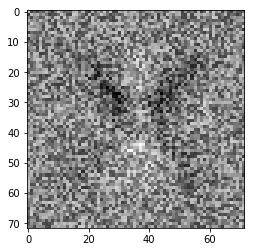

In [171]:
rectangle=df.iloc[:,0]
plt.imshow(rectangle.reshape(72,72), cmap='gray')

- The second one corresponds to the weights of the disk 

/Users/sarahlina/Documents/Documents/Dev/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


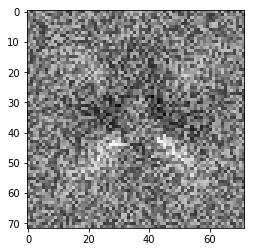

In [34]:
disk=df.iloc[:,1]
plt.imshow(disk.reshape(72,72), cmap='gray')

- And the last one corresponds to the weights of the triangle

/Users/sarahlina/Documents/Documents/Dev/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


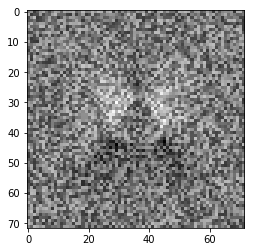

In [35]:
triangle=df.iloc[:,2]
plt.imshow(triangle.reshape(72,72), cmap='gray')

The three images are not really clear but we can see the shape of each figure

# ------------------------------------------------------------------------
# 4. A More Difficult Classification Problem
# ------------------------------------------------------------------------

In [36]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)

Creating data-----
Data Created


In [37]:
#Convert to categorical
target = to_categorical(Y_train)

#Get the input shape
n_cols = X_train.shape[1]

In [38]:
[X_test, Y_test] = generate_test_set_classification()

Creating data-----
Data Created


## 3.1. Linear Model : 

- We first start with the previous linear model that contains only one Dense Layer which corresponds to the output layer

In [39]:
model_adam_linear = Sequential()
model_adam_linear.add(Dense(3, activation='softmax', input_shape = (n_cols,)))
model_adam_linear.compile(optimizer='adam' ,loss='categorical_crossentropy',metrics=['accuracy'])
model_adam_linear.fit(X_train, target, batch_size= 32 ,validation_split=0.3, epochs=100, callbacks = [early_stopping_monitor])

Train on 210 samples, validate on 90 samples
Epoch 1/100
210/210 [==============================] - 0s 2ms/step - loss: 2.6851 - acc: 0.3000 - val_loss: 1.5583 - val_acc: 0.3778
Epoch 2/100
210/210 [==============================] - 0s 106us/step - loss: 1.8148 - acc: 0.3571 - val_loss: 1.8100 - val_acc: 0.3889
Epoch 3/100
210/210 [==============================] - 0s 107us/step - loss: 1.7976 - acc: 0.3714 - val_loss: 1.9952 - val_acc: 0.3111


In [40]:
model_adam_linear.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 56us/step


[2.0065030670166015, 0.32999999960263571]

- We can see that the model that gave us an accuracy of 95% for the previous problem is clearly not adapted to this case
- With a train and test accuracy of 30 % , the model that contains only one layer is not suitable. 


We may think that by adding another layer we will improve our model. We will try to see in the following :

In [181]:
model_adam_linear_2 = Sequential()
model_adam_linear_2.add(Dense(500, activation= 'relu', input_shape = (72,72,1)))
model_adam_linear_2.add(Flatten())
model_adam_linear_2.add(Dense(3, activation='softmax'))
model_adam_linear_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 72, 72, 500)       1000      
_________________________________________________________________
flatten_4 (Flatten)          (None, 2592000)           0         
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 7776003   
Total params: 7,777,003
Trainable params: 7,777,003
Non-trainable params: 0
_________________________________________________________________


In [182]:
model_adam_linear_2.compile(optimizer='adam' ,loss='categorical_crossentropy',metrics=['accuracy'])
model_adam_linear_2.fit(X_train, target, batch_size= 32 ,validation_split=0.3, epochs=100, callbacks = [early_stopping_monitor])

Train on 210 samples, validate on 90 samples
Epoch 1/100
210/210 [==============================] - 8s 37ms/step - loss: 8.5883 - acc: 0.2667 - val_loss: 11.1036 - val_acc: 0.3111
Epoch 2/100
210/210 [==============================] - 7s 32ms/step - loss: 10.2849 - acc: 0.3619 - val_loss: 11.1036 - val_acc: 0.3111
Epoch 3/100
210/210 [==============================] - 6s 30ms/step - loss: 10.2849 - acc: 0.3619 - val_loss: 11.1036 - val_acc: 0.3111
Epoch 4/100
210/210 [==============================] - 6s 30ms/step - loss: 10.2849 - acc: 0.3619 - val_loss: 11.1036 - val_acc: 0.3111


In [183]:
model_adam_linear_2.evaluate(X_test, Y_test)

300/300 [==============================] - 2s 8ms/step


[10.799123980204264, 0.32999999960263571]

#### -----

As we can see, adding an additional layer doesn't improve the accuracy. Which means that the data are not linearly separable. Thus a more complex netword is required.

## 3.2 Convolutional deep network

In [41]:
# Formatting the train input
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
X_train = X_train.astype('float32')
print(X_train.shape)

(300, 72, 72, 1)


In [42]:
# Formatting the test input
X_test = X_test.reshape(X_test.shape[0],  72, 72, 1)
X_test = X_test.astype('float32')
print(X_test.shape)

(300, 72, 72, 1)


# ---------
The first architecture we try is the one described is the statement that contains: 
1. A Convolutional Layer
2. A Pooling Layer
3. A Flatten Layen
4. A Dense layer as output layer

In [ ]:
model_deep = Sequential()
model_deep.add(Conv2D(10, 3, 3, border_mode='same', activation='relu',input_shape=(72, 72, 1)))
model_deep.add(MaxPooling2D(pool_size=(2, 2)))
model_deep.add(Flatten())
model_deep.add(Dense(3, activation='softmax'))

In [44]:
model_deep.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 55491     
Total params: 55,907
Trainable params: 55,907
Non-trainable params: 0
_________________________________________________________________


In [45]:
model_deep.compile(optimizer='adam' ,loss='categorical_crossentropy',metrics=['accuracy'])

In [46]:
early_stopping_monitor = EarlyStopping(patience=3)
model_deep.fit(X_train, target, batch_size= 32 ,validation_split=0.3, epochs=100, callbacks = [early_stopping_monitor], verbose=1)

Train on 210 samples, validate on 90 samples
Epoch 1/100
210/210 [==============================] - 1s 4ms/step - loss: 1.2581 - acc: 0.3571 - val_loss: 1.1466 - val_acc: 0.3778
Epoch 2/100
210/210 [==============================] - 0s 2ms/step - loss: 1.0164 - acc: 0.4905 - val_loss: 0.9719 - val_acc: 0.4778
Epoch 3/100
210/210 [==============================] - 0s 2ms/step - loss: 0.8808 - acc: 0.6381 - val_loss: 0.8780 - val_acc: 0.4667
Epoch 4/100
210/210 [==============================] - 0s 2ms/step - loss: 0.7961 - acc: 0.6619 - val_loss: 0.7809 - val_acc: 0.6889
Epoch 5/100
210/210 [==============================] - 0s 2ms/step - loss: 0.7169 - acc: 0.8000 - val_loss: 0.7307 - val_acc: 0.7222
Epoch 6/100
210/210 [==============================] - 0s 2ms/step - loss: 0.6217 - acc: 0.8190 - val_loss: 0.6779 - val_acc: 0.7444
Epoch 7/100
210/210 [==============================] - 0s 2ms/step - loss: 0.5588 - acc: 0.8238 - val_loss: 0.6482 - val_acc: 0.7333
Epoch 8/100
210/210 [===

In [47]:
model_deep.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 624us/step


[0.69240036725997922, 0.69999999920527145]

- As we can see, by using a deeper model we have improved our significally the accuracy. Which confirm our assuption about the existance of non linear relations whithin the data. 
- Thus a convolutional deep network is more adapted to complex problems such as this one comparing to the linear model

One wants to improve the accuracy by improving the previous architecture of the convolutional deep network

## Improve the architecture:  

To improve the architecture, we add an additional Dense layer at the end of the network to capture the new relations resulting from the previous layers

In [48]:
model_deep_2 = Sequential()
model_deep_2.add(Conv2D(16, (5, 5), activation='relu',input_shape=(72, 72, 1)))
model_deep_2.add(MaxPooling2D(pool_size=(2, 2)))
model_deep_2.add(Flatten())
model_deep_2.add(Dense(200, activation='relu' ))
model_deep_2.add(Dense(3, activation='softmax'))

In [49]:
model_deep_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               3699400   
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 603       
Total params: 3,700,419
Trainable params: 3,700,419
Non-trainable params: 0
_________________________________________________________________


In [50]:
model_deep_2.compile(optimizer='adam' ,loss='categorical_crossentropy',metrics=['accuracy'])

In [51]:
early_stopping_monitor = EarlyStopping(patience=3)
model_deep_2.fit(X_train, target, batch_size= 32 ,validation_split=0.3, epochs=100, callbacks = [early_stopping_monitor], verbose=1)

Train on 210 samples, validate on 90 samples
Epoch 1/100
210/210 [==============================] - 1s 6ms/step - loss: 3.0925 - acc: 0.3143 - val_loss: 1.3931 - val_acc: 0.3778
Epoch 2/100
210/210 [==============================] - 1s 3ms/step - loss: 1.0587 - acc: 0.5000 - val_loss: 0.8667 - val_acc: 0.6222
Epoch 3/100
210/210 [==============================] - 1s 3ms/step - loss: 0.7335 - acc: 0.7095 - val_loss: 0.7153 - val_acc: 0.7667
Epoch 4/100
210/210 [==============================] - 1s 3ms/step - loss: 0.5864 - acc: 0.7952 - val_loss: 0.6359 - val_acc: 0.7778
Epoch 5/100
210/210 [==============================] - 1s 3ms/step - loss: 0.5048 - acc: 0.8524 - val_loss: 0.5880 - val_acc: 0.7444
Epoch 6/100
210/210 [==============================] - 1s 3ms/step - loss: 0.4230 - acc: 0.9000 - val_loss: 0.5662 - val_acc: 0.7778
Epoch 7/100
210/210 [==============================] - 1s 3ms/step - loss: 0.3470 - acc: 0.9333 - val_loss: 0.5622 - val_acc: 0.7111
Epoch 8/100
210/210 [===

In [52]:
model_deep_2.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 708us/step


[0.62261476119359338, 0.76333333333333331]

As predicted, the previous architecture can be improved. As we can notice, the train accuracy has reached 95 % and the test one 76% which can be considered as satisfactory result for a such complex problem

### The main benefit of having a deeper model is being able to do more non-linear transformations of the input and drawing a more complex decision boundary. 

# ------------------------------------------------------------------------
# 5. A Regression Problem
# ------------------------------------------------------------------------

In [53]:
[X_train_reg, Y_train_reg] = generate_dataset_regression(300, 20)

Creating data-----
Data Created


In [106]:
[X_test_reg, Y_test_reg] = generate_test_set_regression()

Creating data-----
Data Created


In [55]:
X_train_reg.shape

(300, 5184)

In [109]:
# Formatting the input
X_train_reg = X_train_reg.reshape(X_train_reg.shape[0], 72, 72, 1)
#X_train_reg = X_train_reg.astype('float32')
print(X_train_reg.shape)

# Formatting the input
X_test_reg = X_test_reg.reshape(X_test_reg.shape[0], 72, 72, 1)
#X_test_reg = X_test_reg.astype('float32')
print(X_test_reg.shape)

(300, 72, 72, 1)
(300, 72, 72, 1)


49


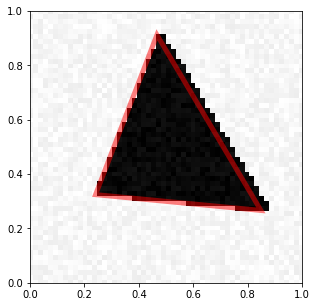

In [140]:
i=rd.randint(0,299)
print(i)
visualize_prediction(X_train_reg[i], Y_train_reg[i])

### ---- 1. Using the previous model : 

In [187]:
model_deep_reg = Sequential()
model_deep_reg.add(Conv2D(16, (5, 5), activation='relu',input_shape=(72, 72, 1)))
model_deep_reg.add(MaxPooling2D(pool_size=(2, 2)))
model_deep_reg.add(Flatten())
model_deep_reg.add(Dense(200, activation='relu' ))
model_deep_reg.add(Dense(6, activation='linear'))    # we change softmax to linear since it's a regression problem and not a classification one

In [188]:
model_deep_reg.compile(optimizer='adam' ,loss='categorical_crossentropy',metrics=['accuracy'])

In [189]:
model_deep_reg.fit(X_train_reg, Y_train_sorted, batch_size= 16 , epochs=100)

Epoch 1/100
300/300 [==============================] - 2s 7ms/step - loss: 22.1361 - acc: 0.5267
Epoch 2/100
300/300 [==============================] - 1s 4ms/step - loss: 32.2252 - acc: 0.5267
Epoch 3/100
300/300 [==============================] - 1s 4ms/step - loss: 32.2235 - acc: 0.5267
Epoch 4/100
300/300 [==============================] - 1s 4ms/step - loss: 32.2235 - acc: 0.5267
Epoch 5/100
300/300 [==============================] - 1s 4ms/step - loss: 32.2235 - acc: 0.5267
Epoch 6/100
300/300 [==============================] - 1s 5ms/step - loss: 32.2235 - acc: 0.5267
Epoch 7/100
300/300 [==============================] - 1s 5ms/step - loss: 32.2235 - acc: 0.5267
Epoch 8/100
300/300 [==============================] - 1s 4ms/step - loss: 32.2235 - acc: 0.5267
Epoch 9/100
300/300 [==============================] - 1s 4ms/step - loss: 32.2235 - acc: 0.5267
Epoch 10/100
300/300 [==============================] - 1s 4ms/step - loss: 32.2235 - acc: 0.5267
Epoch 11/100
300/300 [=======

In [192]:
model_deep_reg.evaluate(X_test_reg, Y_test_reg)

300/300 [==============================] - 0s 704us/step


[31.912330729166666, 0.18666666686534883]

- The results obtained are not satisfactory, with only 50% of accuracy for the train the previous model gives less that 20% of accuracy on the test dataset

### ---- 2. Using a nnormalization / sorting : 

The idea is to first sort the Y_train before training the model. The sorting is done as follow:
    - For each image, we sort the 3 couples of coordinates with respect to the first axis x 

In [58]:
def sort_y(Y):
    y_reshaped = map(lambda i: np.array(sorted(Y[i].reshape(3,2),key=lambda x:x[0])).reshape(6), range(len(Y)))
    return np.array(y_reshaped)

In [107]:
Y_train_sorted = sort_y(Y_train_reg)
Y_test_sorted = sort_y(Y_test_reg)

In [60]:
# Define the model
# We choose to re use the same model as previously
model = Sequential()
model.add(Conv2D(16, kernel_size=(5,5), activation='relu', input_shape=(72,72,1)))
model.add(MaxPooling2D(pool_size=(2,2), padding="same"))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(6,activation='linear'))

In [61]:
model.compile(optimizer='adam', loss='mean_squared_error' ,metrics=['accuracy'] )
model.fit(X_train_reg, Y_train_sorted, batch_size= 16 , epochs=100)

Epoch 1/100
300/300 [==============================] - 2s 5ms/step - loss: 1.2446 - acc: 0.2267
Epoch 2/100
300/300 [==============================] - 1s 3ms/step - loss: 0.1218 - acc: 0.3033
Epoch 3/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0573 - acc: 0.4867
Epoch 4/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0481 - acc: 0.5300
Epoch 5/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0429 - acc: 0.5500
Epoch 6/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0390 - acc: 0.5600
Epoch 7/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0349 - acc: 0.5867
Epoch 8/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0313 - acc: 0.5600
Epoch 9/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0280 - acc: 0.5767
Epoch 10/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0253 - acc: 0.6333A: 0s - loss: 0.0262 - acc
Epoch 11/100


300/300 [==============================] - 1s 3ms/step - loss: 7.4711e-04 - acc: 0.9467
Epoch 85/100
300/300 [==============================] - 1s 3ms/step - loss: 7.1487e-04 - acc: 0.9267
Epoch 86/100
300/300 [==============================] - 1s 3ms/step - loss: 7.2283e-04 - acc: 0.9500
Epoch 87/100
300/300 [==============================] - 1s 3ms/step - loss: 6.8185e-04 - acc: 0.9467
Epoch 88/100
300/300 [==============================] - 1s 3ms/step - loss: 6.7947e-04 - acc: 0.9467
Epoch 89/100
300/300 [==============================] - 1s 3ms/step - loss: 7.0353e-04 - acc: 0.9333
Epoch 90/100
300/300 [==============================] - 1s 3ms/step - loss: 6.8864e-04 - acc: 0.9367
Epoch 91/100
300/300 [==============================] - 1s 3ms/step - loss: 6.8900e-04 - acc: 0.9467
Epoch 92/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0116 - acc: 0.7700
Epoch 93/100
300/300 [==============================] - 1s 3ms/step - loss: 0.0067 - acc: 0.8100
Epoch 94/10

In [62]:
model.evaluate(X_test_reg, Y_test_sorted)

300/300 [==============================] - 0s 833us/step


[0.032849815239508945, 0.60999999920527137]

## We can see that by simply sorting our Y_train the same model gives a much higher accuracy reaching 92% for the train and 60% for the test

- To have a better view of the result, we plot some of the predicted vales 

In [110]:
preds_reg_sorted= model.predict(X_test_reg)

In [163]:
range_test = list(range(299))

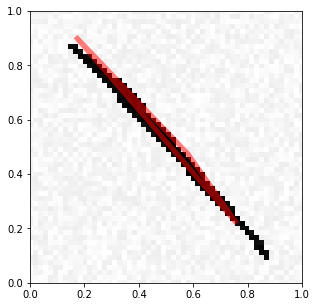

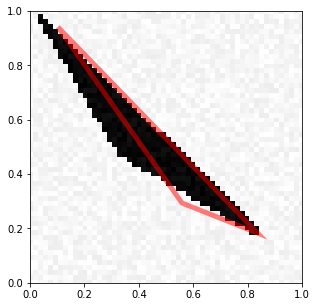

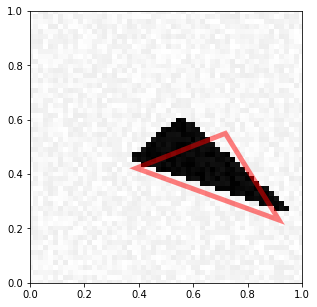

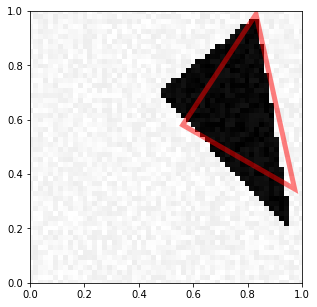

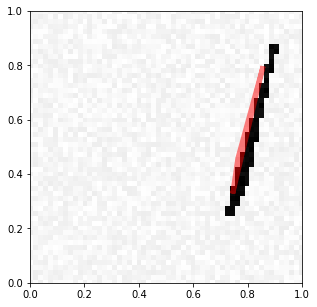

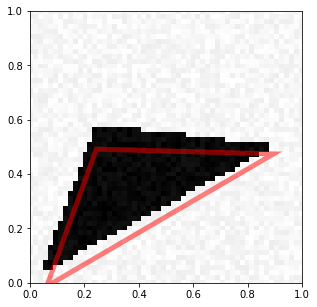

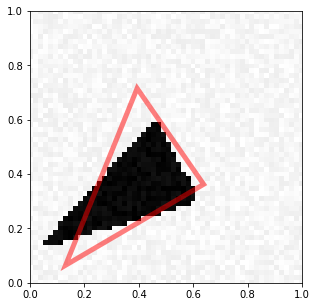

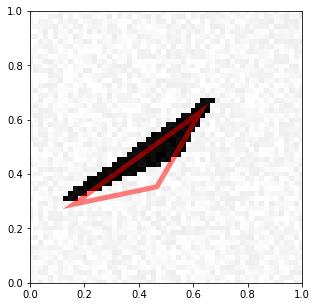

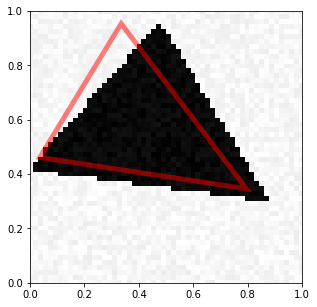

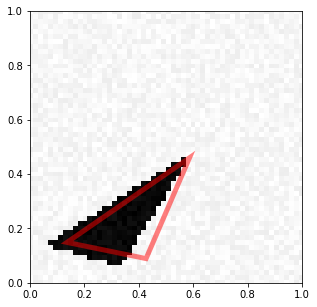

In [168]:
idx_img = rd.sample(range_test, 10)
for i in idx_img :
    visualize_prediction(X_test_reg[i], preds_reg_sorted[i])

## The results obtained are not 100% perfect but they fit quite well the general shape of our triangles and capture their location in the figure

# -------------------------------------------------------------------------------------------
# Bonus Question: 

## -- Redefine the generate functions 

For this first part we redefine all the generation function by returning for each a couple composed of one figure generated witouh noise and another one that contains noise

In [67]:
def generate_a_rectangle_2(noise, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0) 

In [68]:
def generate_a_disk_2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise) , generate_a_drawing(figsize, U, V, 0) 

In [69]:
def generate_a_triangle_2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    
    imdata = generate_a_drawing(figsize, U, V, 0)
    imdata_noise = generate_a_drawing(figsize, U, V, noise)
    return [imdata_noise,imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

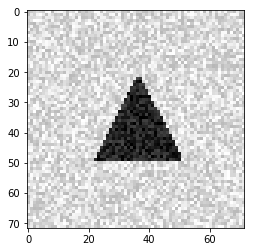

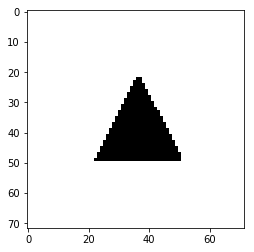

In [70]:
[im, im_noise, v] = generate_a_triangle_2(100, False)
plt.imshow(im.reshape(72,72), cmap='gray')
plt.show()
plt.imshow(im_noise.reshape(72,72), cmap='gray')
plt.show()

In [81]:
def generate_a_dataset(nb_samples, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle_2(0)[0].shape[0]
    X = np.zeros([nb_samples,im_size])   #Images with noise
    Y = np.zeros([nb_samples,im_size])   #Images without noise
    for i in range(nb_samples):
        category = np.random.randint(3)
        #Each image is generated with a different random level of noise
        noise =rd.randint(20,150)
        if category == 0:
            X[i] , Y[i]= generate_a_rectangle_2(noise, free_location)
        elif category == 1: 
            X[i] , Y[i]= generate_a_disk_2(noise, free_location)
        else:
            [X[i], Y[i], V] = generate_a_triangle_2(noise, free_location)
    X = (X + 0) / (255 + 2 * 0)
    Y = (Y + noise) / (255 + 2 * noise)
    return [X, Y]

In [82]:
[X_train_noise, Y_train_noise] = generate_a_dataset(300)

In [83]:
[X_test_noise, Y_test_noise] = generate_a_dataset(300)

In [84]:
# Formatting the input for the training
X_train_noise = X_train_noise.reshape(X_train_noise.shape[0], 72, 72, 1)
X_train_noise = X_train_noise.astype('float32')
print(X_train_noise.shape)

# Formatting the output for the trainind
Y_train_noise = Y_train_noise.reshape(Y_train_noise.shape[0], 72, 72, 1)
Y_train_noise = Y_train_noise.astype('float32')
print(Y_train_noise.shape)


# Formatting the input
Y_test_noise = Y_test_noise.reshape(Y_test_noise.shape[0], 72, 72, 1)
Y_test_noise = Y_test_noise.astype('float32')
print(Y_test_noise.shape)

(300, 72, 72, 1)
(300, 72, 72, 1)
(300, 72, 72, 1)


In [85]:
from keras.layers import Input
input_img = Input(shape=(72,72,1))

According to the hourglass network architecture, the model should contain 2 part :
- An encoded part: that contains a convolutional + a pool layers
- A decoder part: that contains an unsampling + convolutional layers

The two parts are symetric

In [86]:
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 72, 72, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 1)         289       
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


In [87]:
autoencoder.fit(X_train_noise, Y_train_noise,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_split=0.3)

Train on 210 samples, validate on 90 samples
Epoch 1/100
210/210 [==============================] - 3s 13ms/step - loss: 0.7251 - val_loss: 0.6959
Epoch 2/100
210/210 [==============================] - 2s 10ms/step - loss: 0.6896 - val_loss: 0.6624
Epoch 3/100
210/210 [==============================] - 2s 10ms/step - loss: 0.6545 - val_loss: 0.6217
Epoch 4/100
210/210 [==============================] - 2s 10ms/step - loss: 0.6158 - val_loss: 0.5906
Epoch 5/100
210/210 [==============================] - 2s 10ms/step - loss: 0.5874 - val_loss: 0.5705
Epoch 6/100
210/210 [==============================] - 2s 10ms/step - loss: 0.5698 - val_loss: 0.5590
Epoch 7/100
210/210 [==============================] - 2s 10ms/step - loss: 0.5599 - val_loss: 0.5528
Epoch 8/100
210/210 [==============================] - 2s 10ms/step - loss: 0.5548 - val_loss: 0.5493
Epoch 9/100
210/210 [==============================] - 2s 11ms/step - loss: 0.5515 - val_loss: 0.5460
Epoch 10/100
210/210 [===============

In [90]:
pred_noise = autoencoder.predict(X_train_noise)

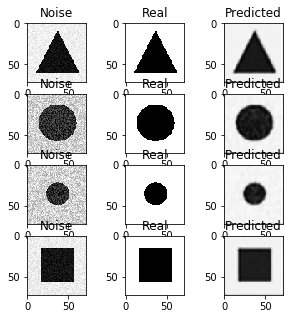

In [105]:
nb_img_test = 4
pos =1

fig, axes = plt.subplots(4, 3,figsize=(5,5))

for j in range(nb_img_test):
    
    i=rd.randint(0,299)   
    
    axes[j, 0].imshow(X_train_noise[i].reshape(72,72), cmap='gray')
    axes[j, 0].set_title('Noise')

    axes[j, 1].imshow(Y_train_noise[i].reshape(72,72), cmap='gray')
    axes[j, 1].set_title('Real')
    
    axes[j, 2].imshow(pred_noise[i].reshape(72,72), cmap='gray')
    axes[j, 2].set_title('Predicted')

We can see that for different levels of noise, the model managed to capture the figure and reduce the noise around it